In [1]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union
import pprint

from langchain_openai import ChatOpenAI
from FPGA_AGI.chains import WebsearchCleaner

from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-turbo', temperature=0)
gpt4 = ChatOpenAI(model='gpt-4', temperature=0)


webcleaner = WebsearchCleaner.from_llm(llm=bigllm)

def clean_web(concatenated_content):
    try:
        cleaned_concatenated_content = webcleaner.invoke(concatenated_content)
        cleaned_concatenated_content = cleaned_concatenated_content.cleaned
    except:
        cleaned_concatenated_content = concatenated_content.replace('\n\n', '')
    return cleaned_concatenated_content

def context_from_web(url):
    loader = RecursiveUrlLoader(
        url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs = loader.load()

    # Add 
    #docs.extend([*docs_pydantic, *docs_sq])

    # Sort the list based on the URLs in 'metadata' -> 'source'
    d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
    d_reversed = list(reversed(d_sorted))

    # Concatenate the 'page_content' of each sorted dictionary
    concatenated_content = "\n\n\n --- \n\n\n".join(
        [doc.page_content for doc in d_reversed]
    )
    cleaned_concatenated_content = clean_web(concatenated_content)
    return cleaned_concatenated_content


# Tests

## Simple RISC V CPU

In [3]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

rescv_concatenated_content = context_from_web("""https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html""")

riscv_requirements = requirement_chain.invoke(
    {"objective": """Design a simple educational RISC-V CPU. Make sure that your code is synthesizable and can aesily fit on a zynq7 device. The coding language must be hls c++. The code must be supplied with a lot of comments for educational purposes.""", 
     "context" : rescv_concatenated_content}
)

# FFT

In [4]:
fft_concatenated_content = context_from_web("""https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm""")

fft_requirements = requirement_chain.invoke(
    {"objective": """Build a 128 point fft circuit which is using two 64 point fft modules (named fft64) to compute the 128 point fft. You do not need to design the 64 point fft devices. You can assume that they just exist.
     the input to the fft module is an array of 128 double precision fixed point real numbers (such as a DSP signal measured elsewhere.) The implementation language must be HLS C++. The design must be optimized for maximum performance (speed.)
     The design must be commented with comments indicating where the design is in fact optimized for performance.""", 
     "context" : fft_concatenated_content})

# Quadruple precision floating point

In [5]:
float128_concatenated_content = context_from_web("""https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format""")

float128_requirements = requirement_chain.invoke(
    {"objective": """
     Build a quadrouple precision floating point (not the fixed point) exponentiation module. You have to code this 128 bit floating point representation from scratch, using the context I provided, and code the computations based on this representation.""", 
     "context" : float128_concatenated_content}
)

# Knowledge base (vector database)

In [6]:
# retriever

from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import chromadb

embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
if os.path.isdir('knowledge_base'):
    persistent_client = chromadb.PersistentClient(path="./knowledge_base")
    pdfsearch = Chroma(client=persistent_client, embedding_function=embeddings_3_small)
else:
    pages = []
    for item in ["https://arxiv.org/pdf/1502.07055", "https://arxiv.org/pdf/1810.06885", "https://arxiv.org/pdf/1808.02521", "https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"]: # 
        loader = PyPDFLoader(item, extract_images=True) #"https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"
        pages += loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = text_splitter.split_documents(pages)
    pdfsearch = Chroma.from_documents(texts, embeddings_3_small, collection_name= "knowledge_base", persist_directory="./knowledge_base")

In [8]:
#retriever=pdfsearch.as_retriever(search_kwargs={"k": 2})
#retriever.get_relevant_documents('FFT algorithm')

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

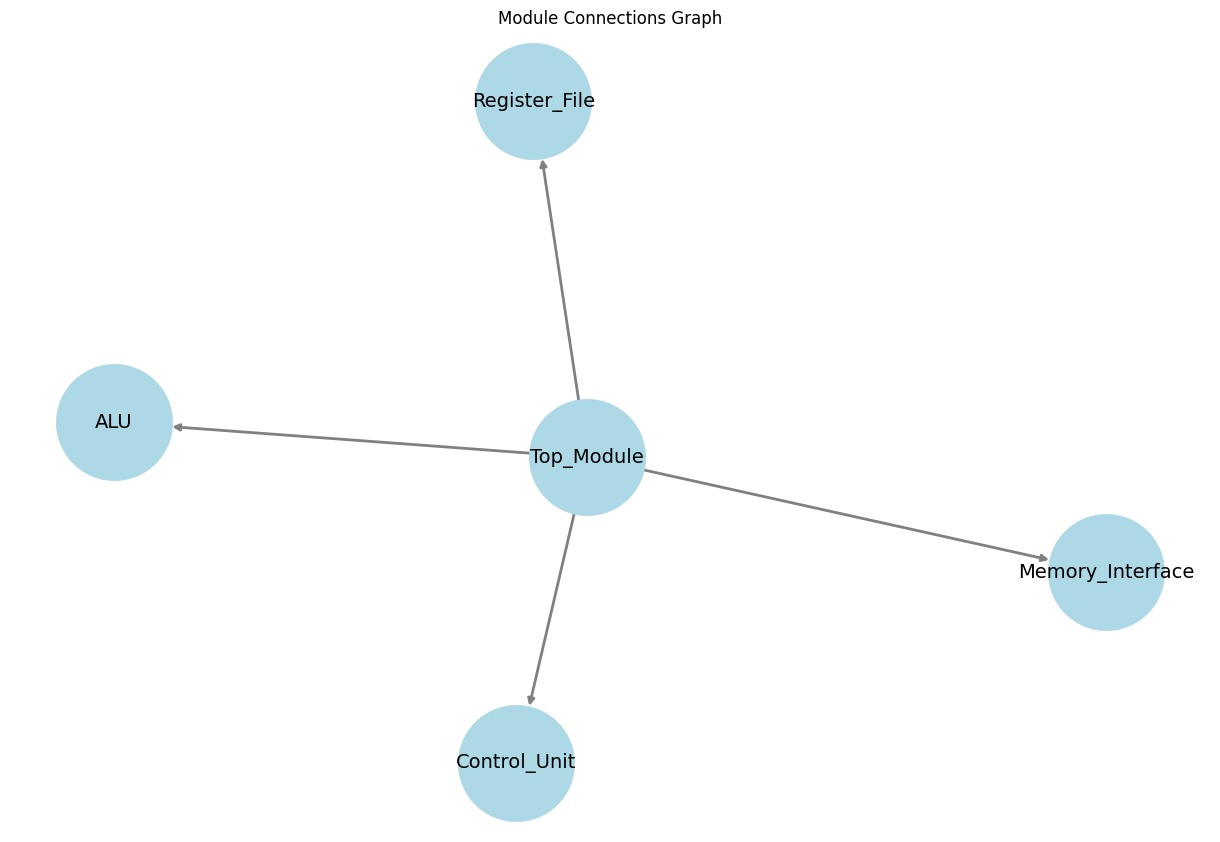

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

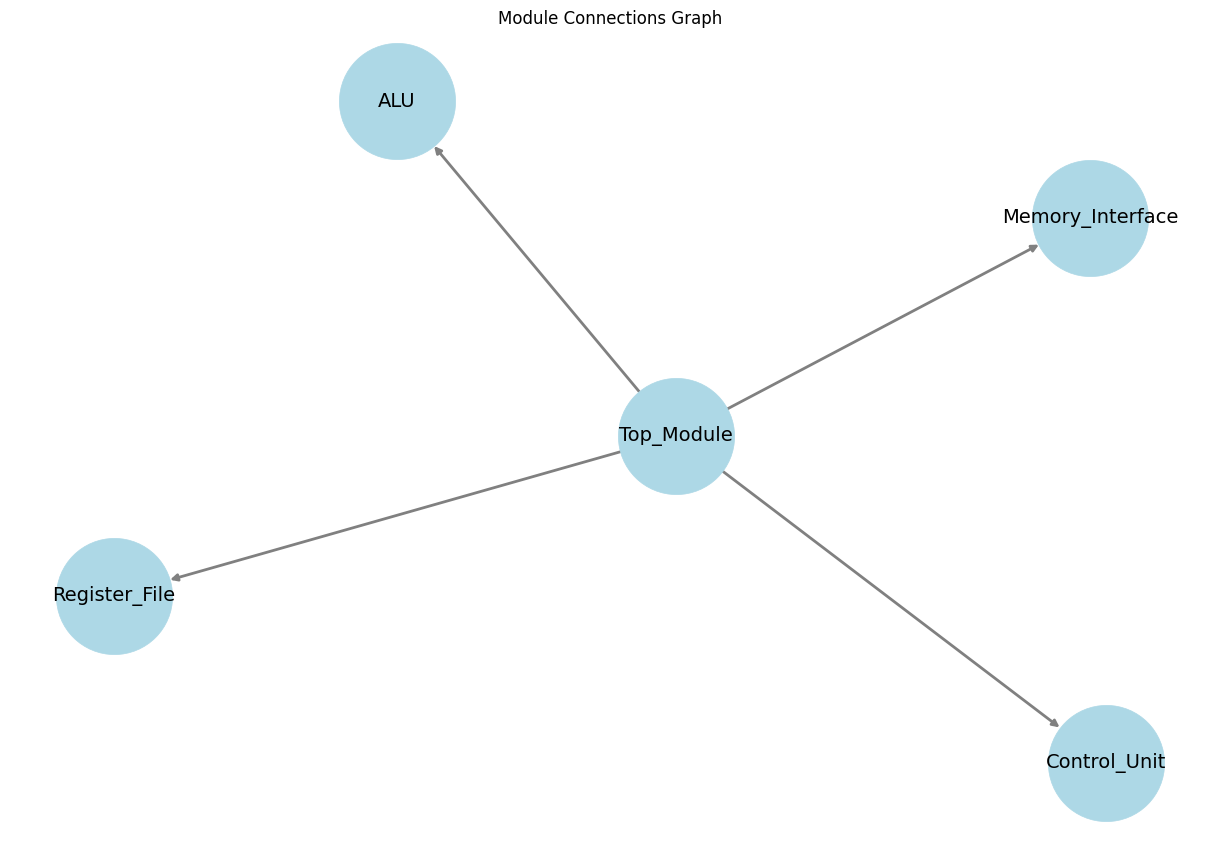

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

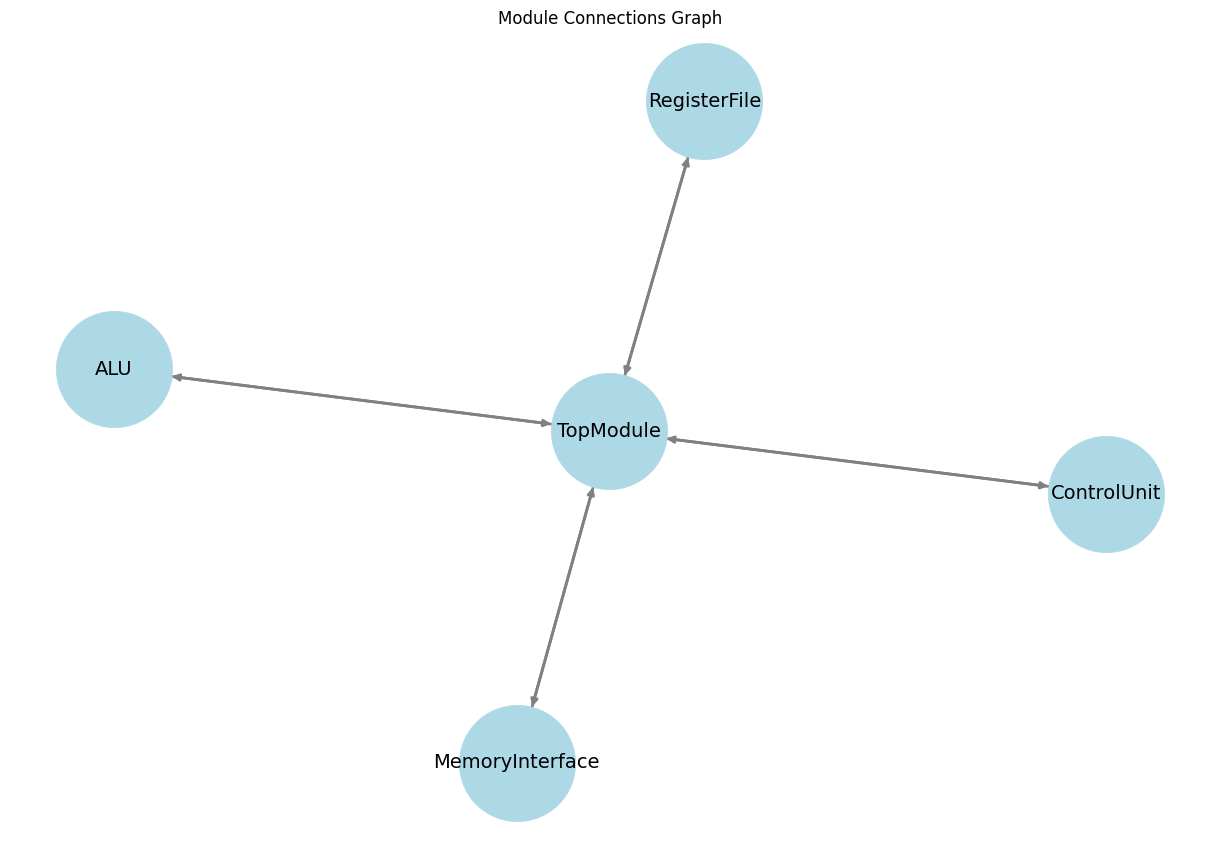

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

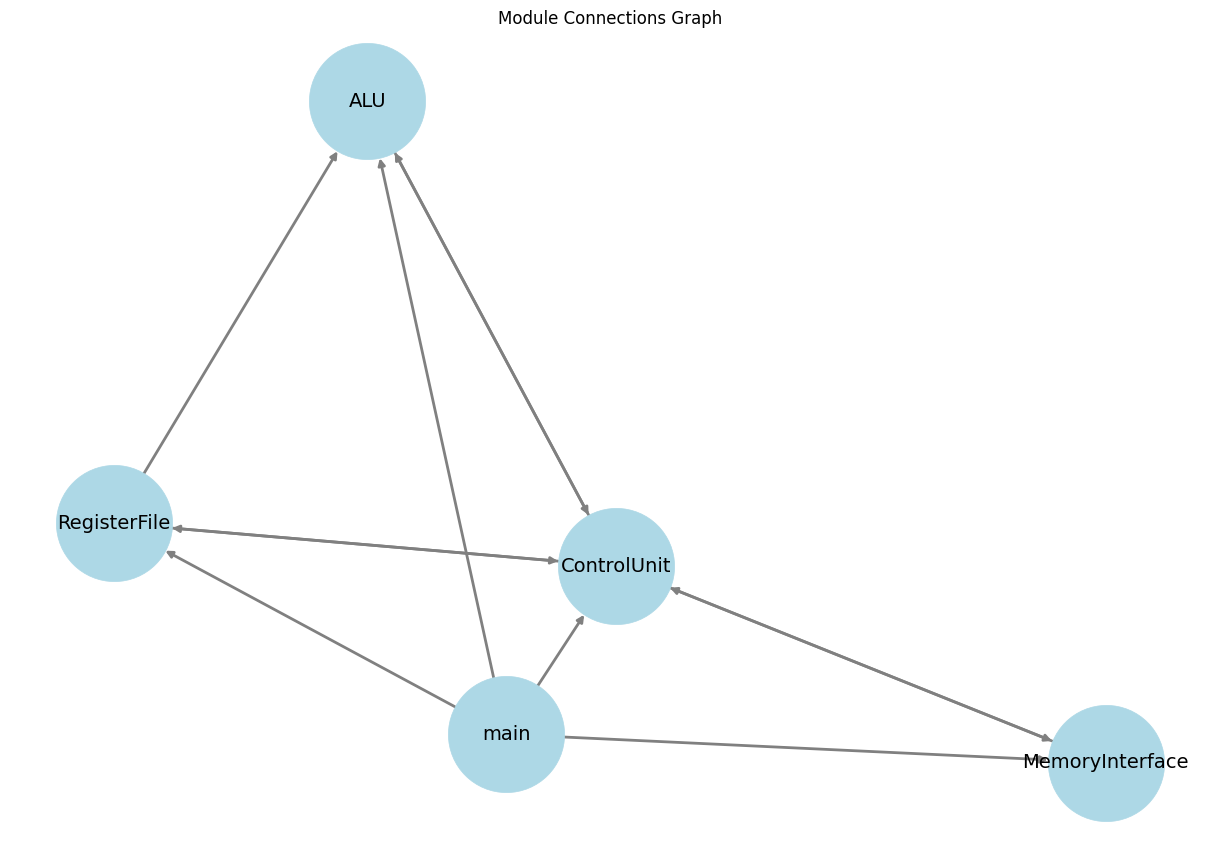

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

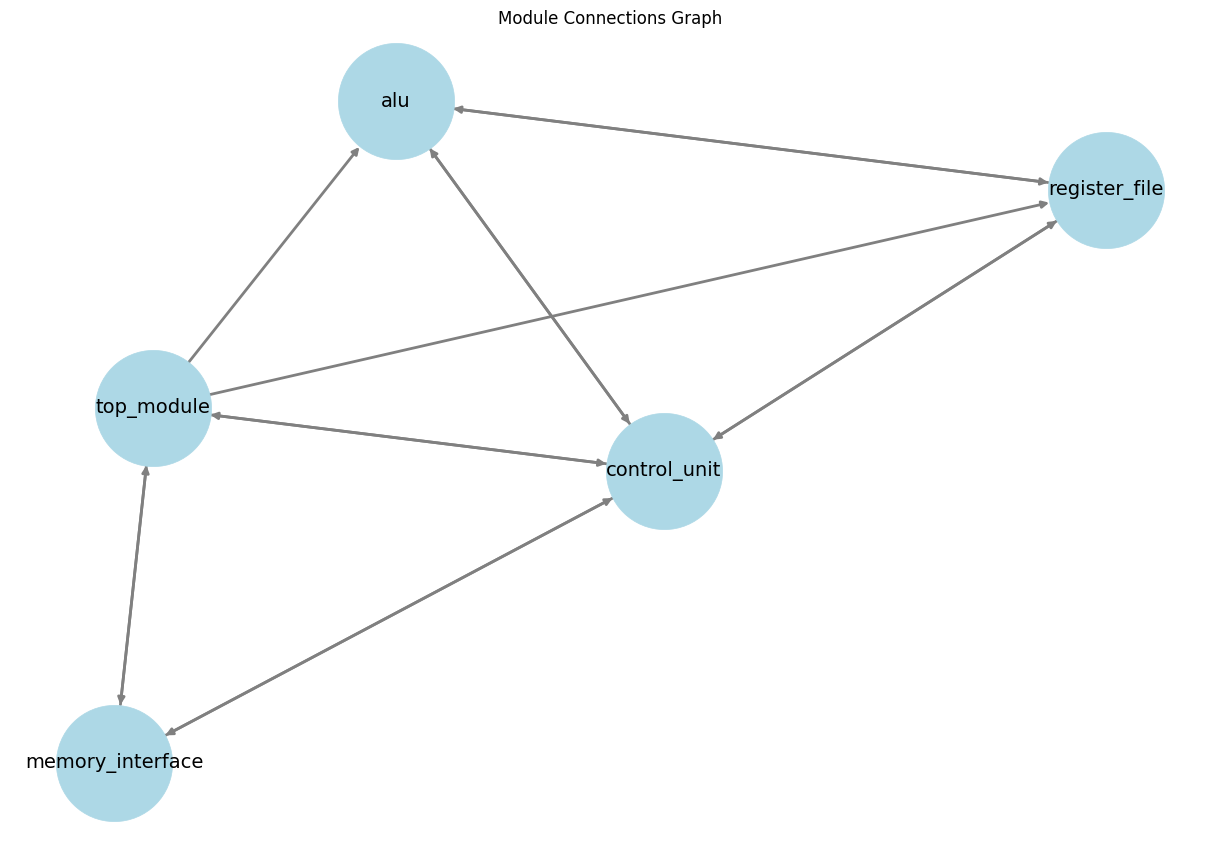

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

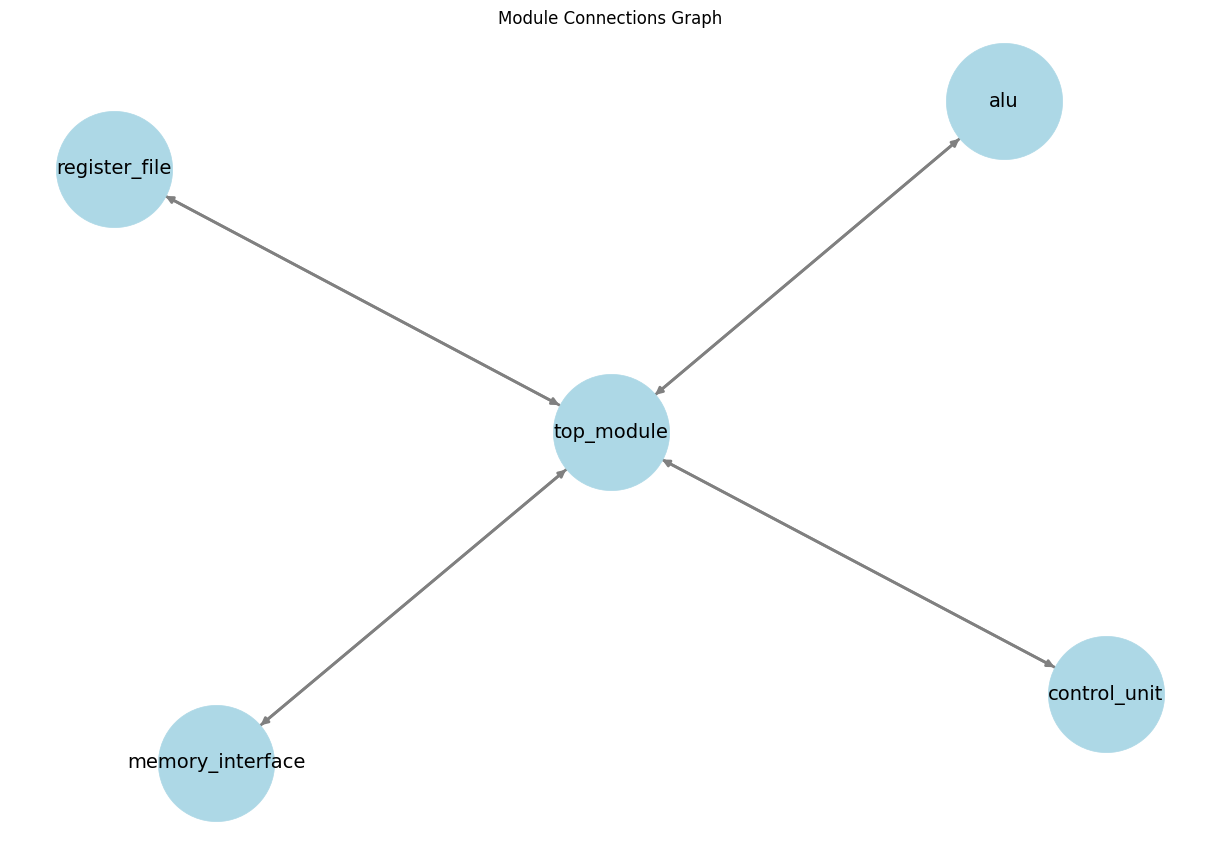

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

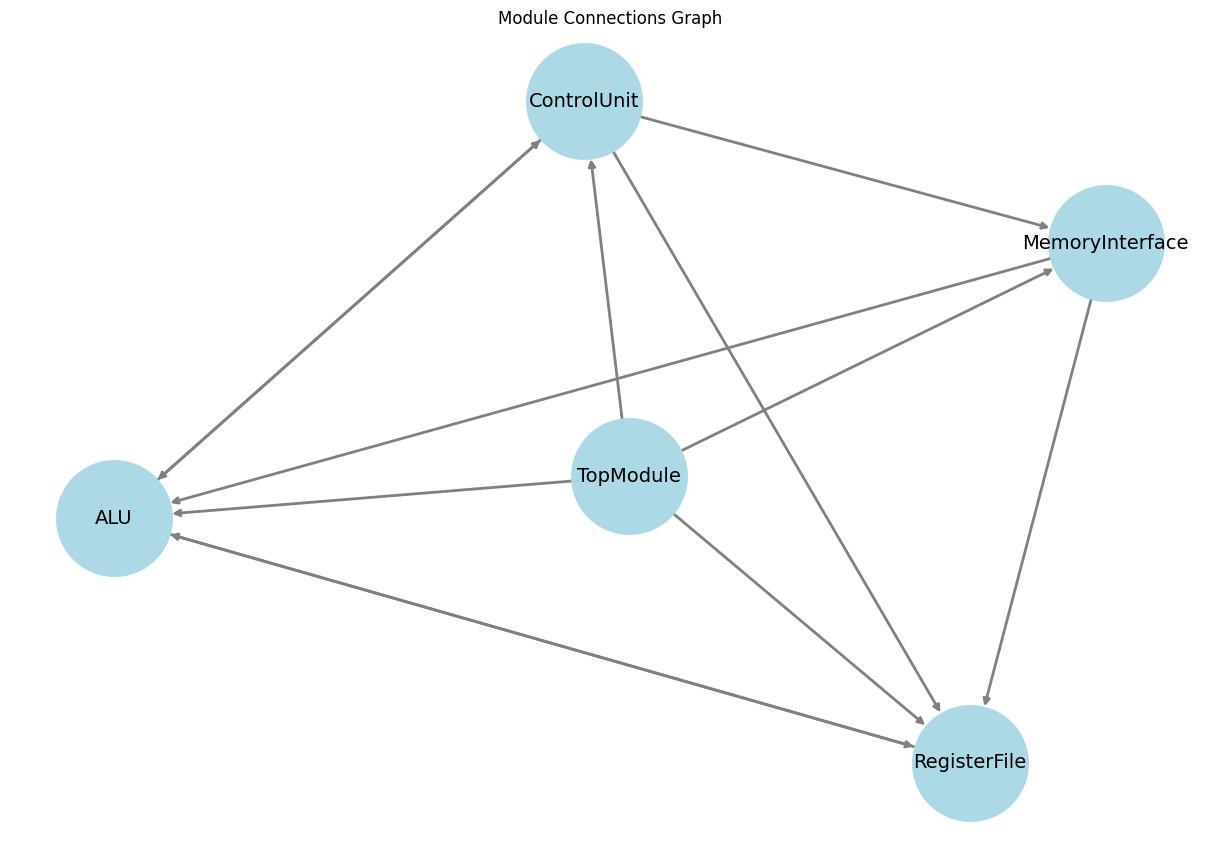

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

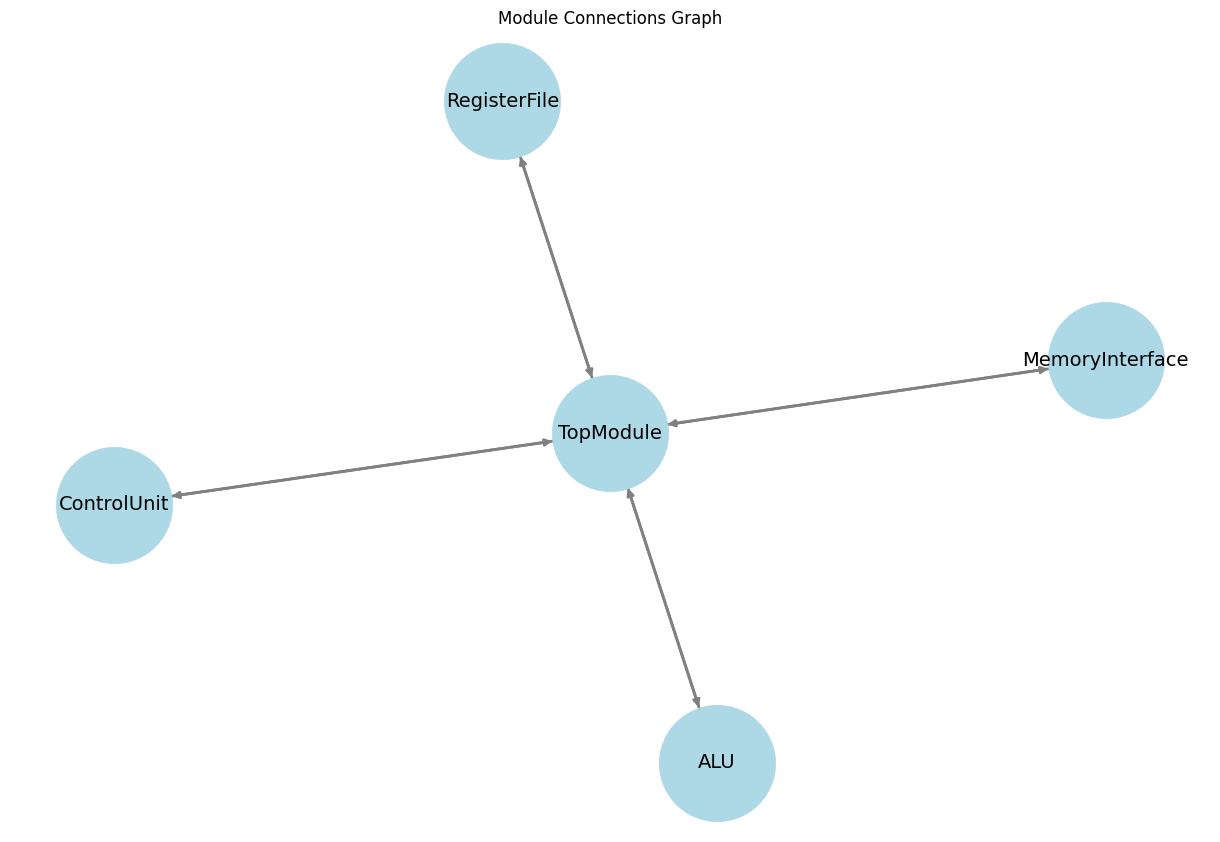

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

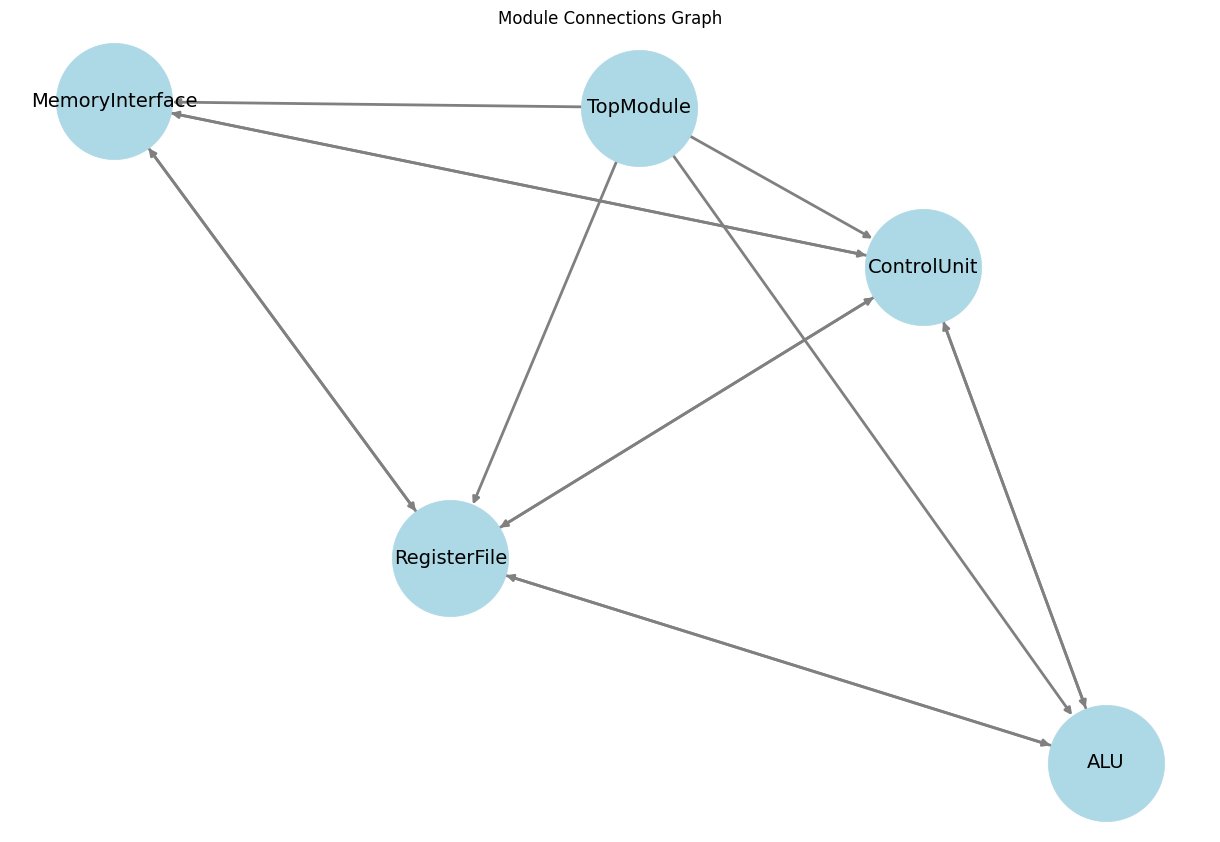

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a simple educational RISC-V CPU using HLS C++.', 'Ensure the HLS C++ code is synthesizable and fits on a Zynq-7 FPGA device.', 'Provide extensive comments within the code for educational purposes.']\n                    requirements:\n                    ['Implement a RISC-V CPU architecture capable of executing basic RISC-V instructions such as load, store, add, subtract, logical operations, and control flow.', 'Design the CPU to be compatible with the Zynq-7 FPGA, ensuring efficient use of resources to fit the design within the FPGA constraints.', 'Utilize HLS C++ for the implementation, leveraging its features to efficiently map high-level constructs to hardware.', 'Include detailed comments explaining each part of the code and its functionality, sui

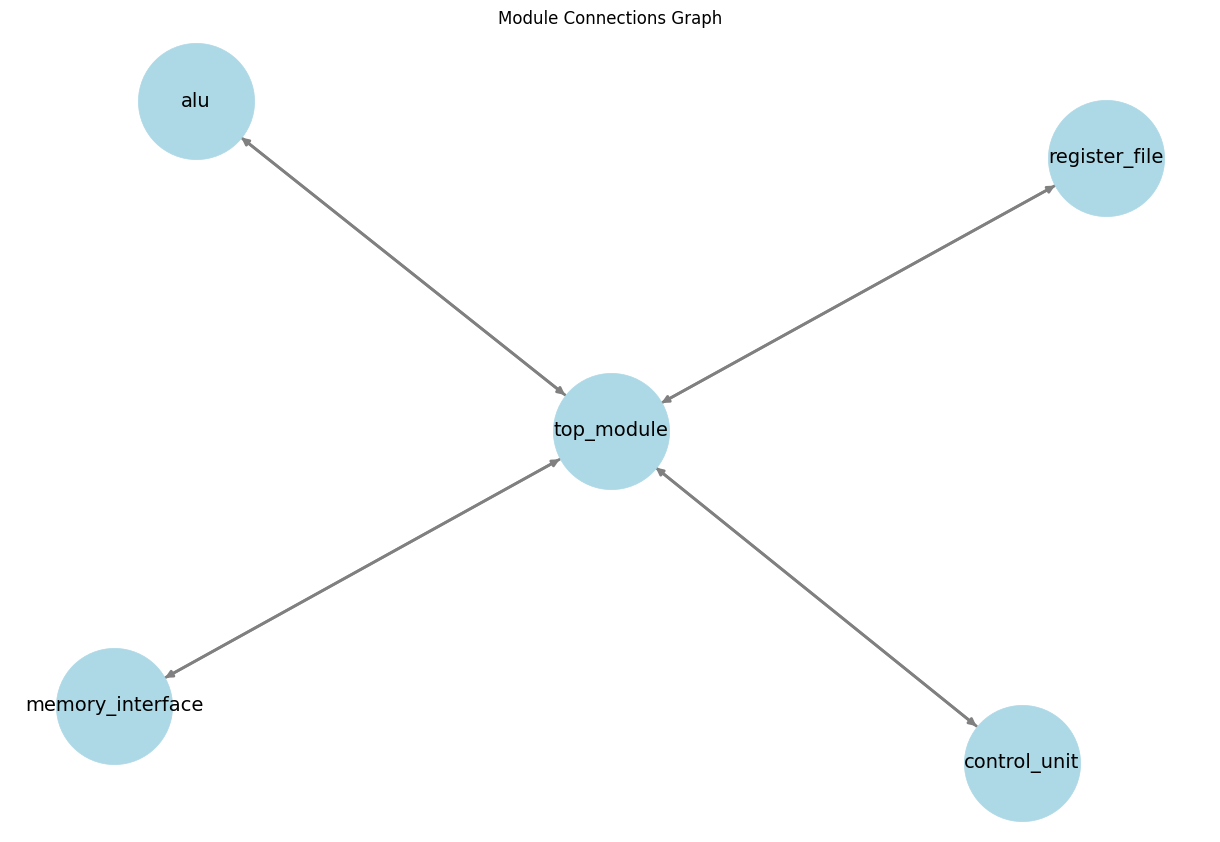

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

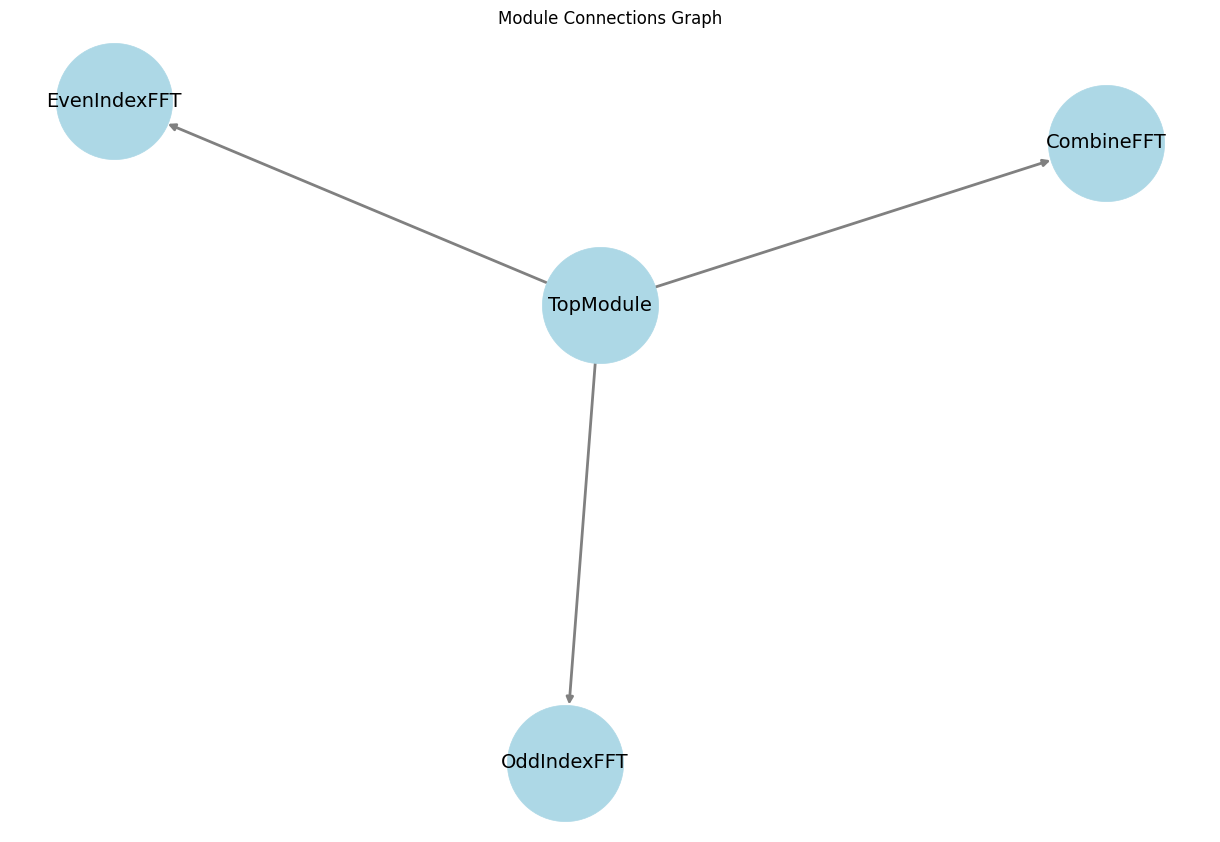

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

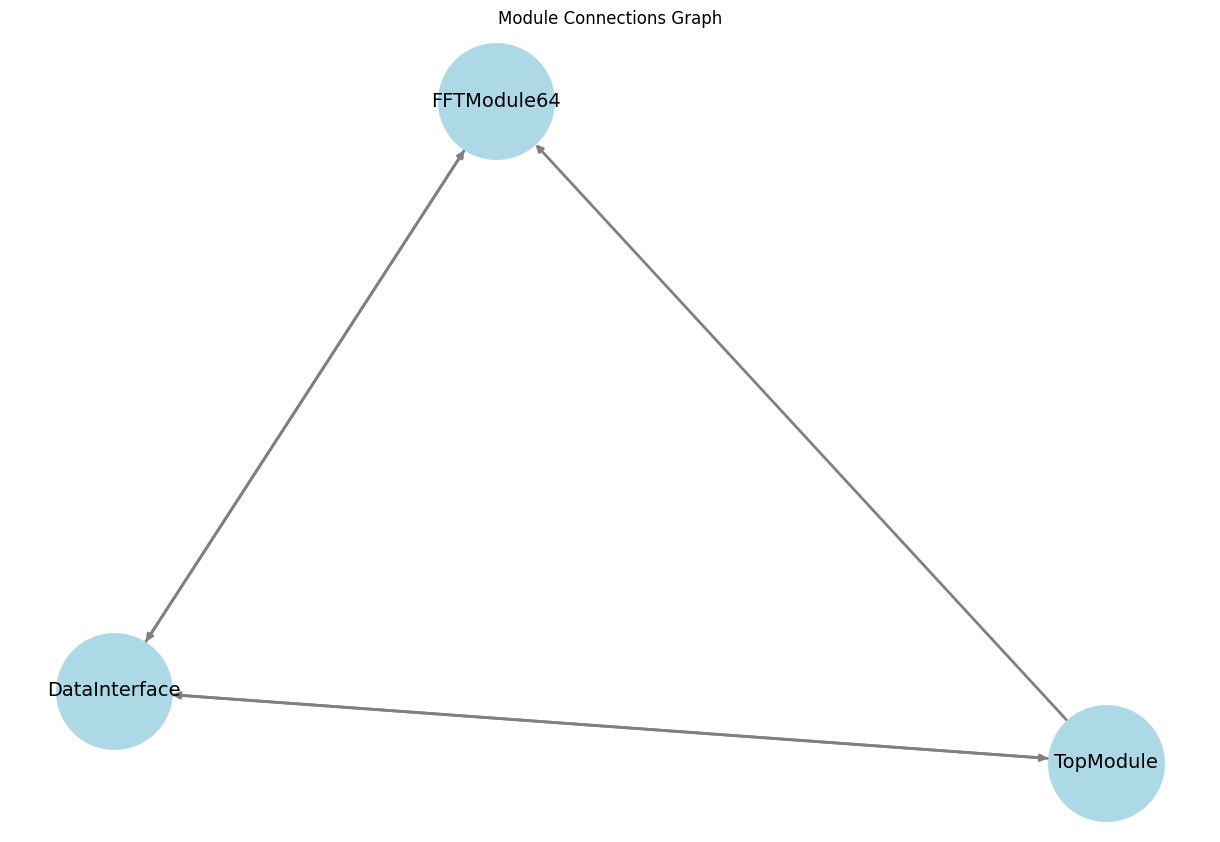

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

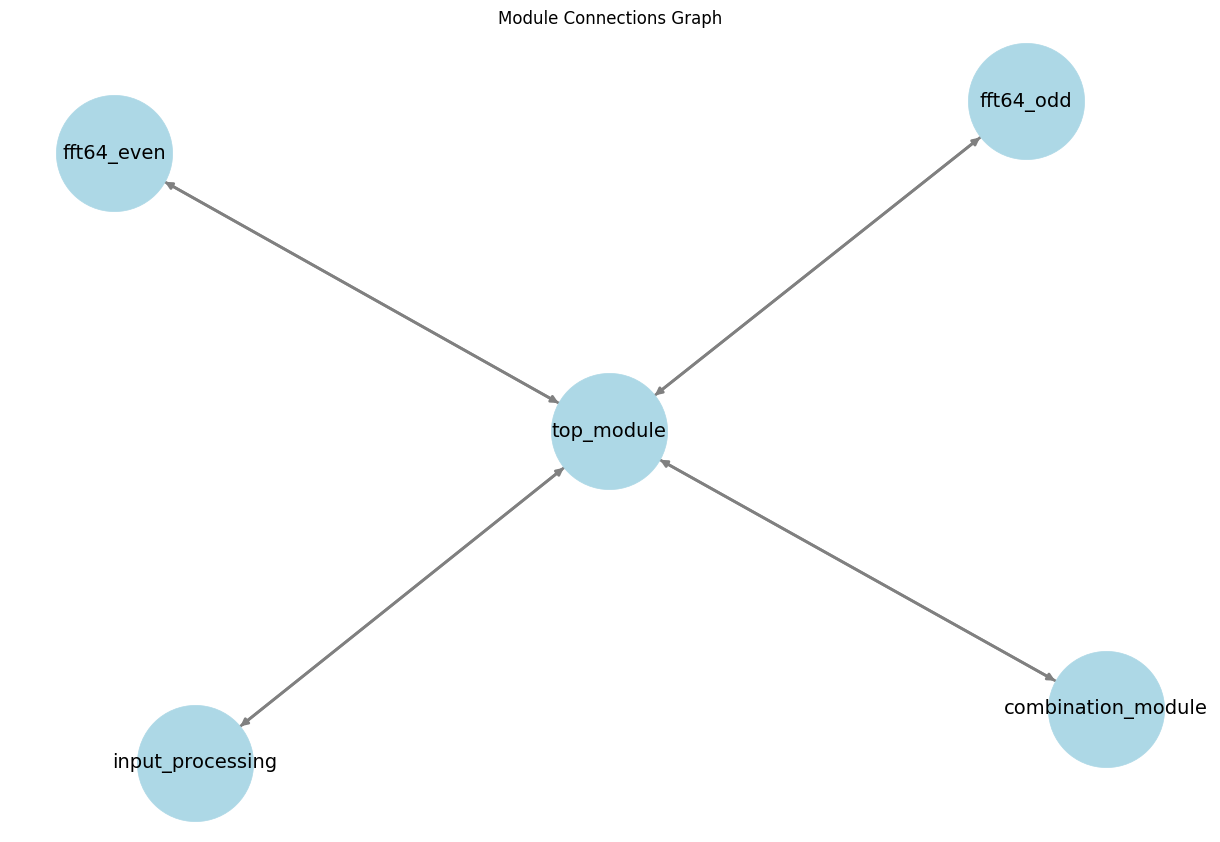

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

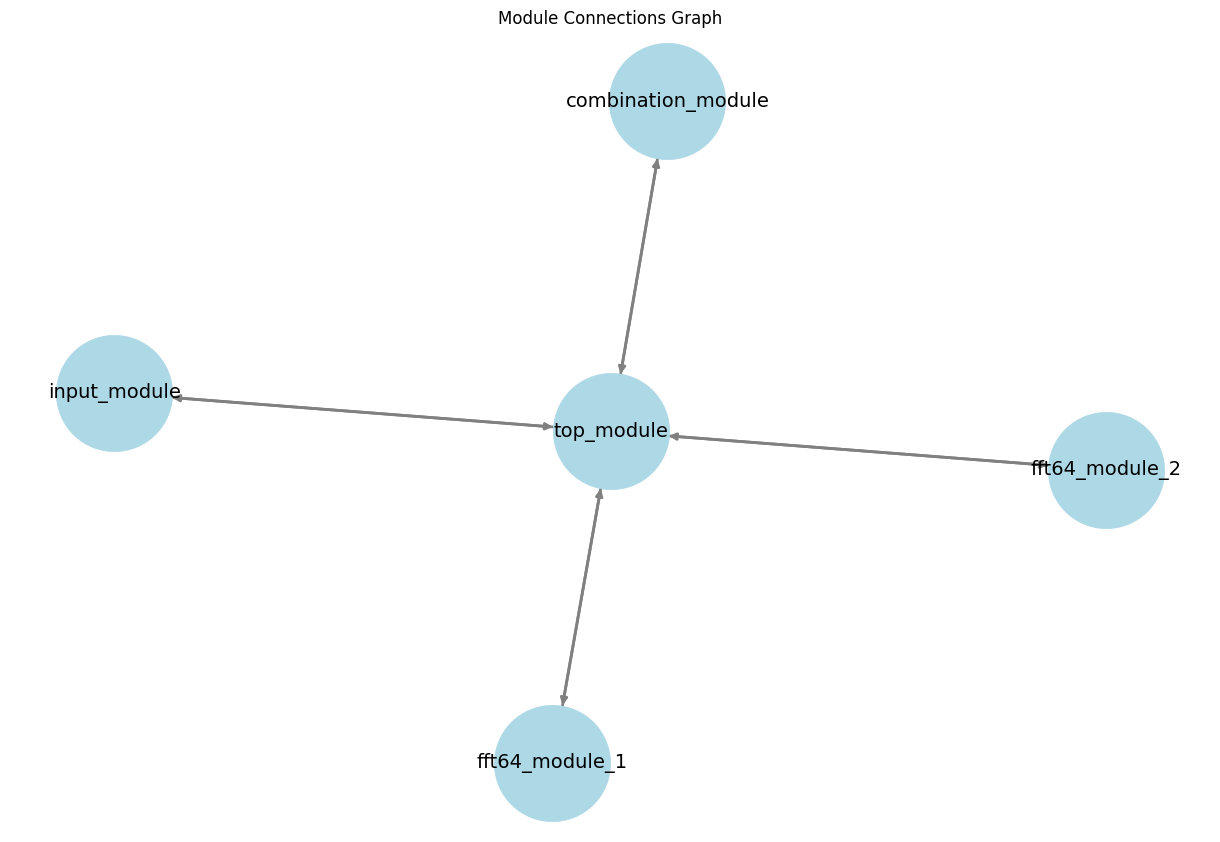

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

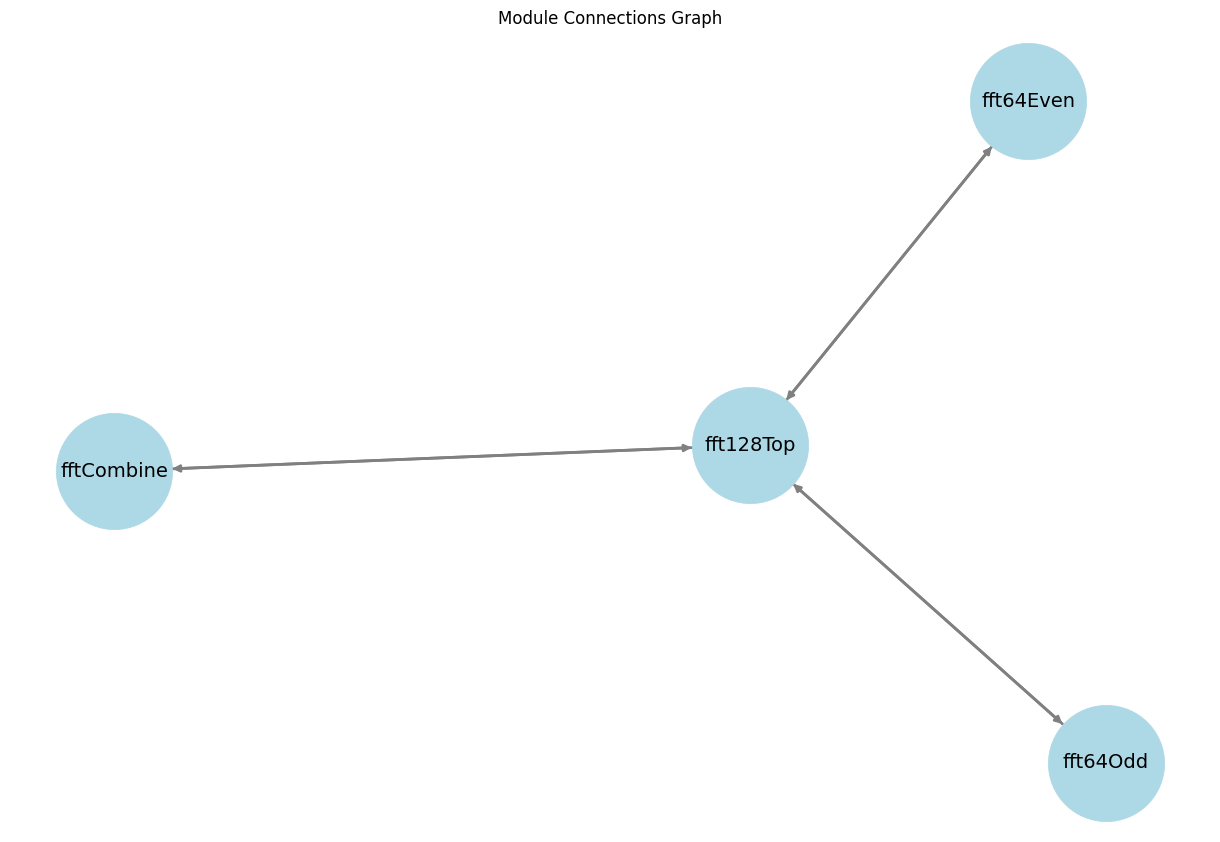

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

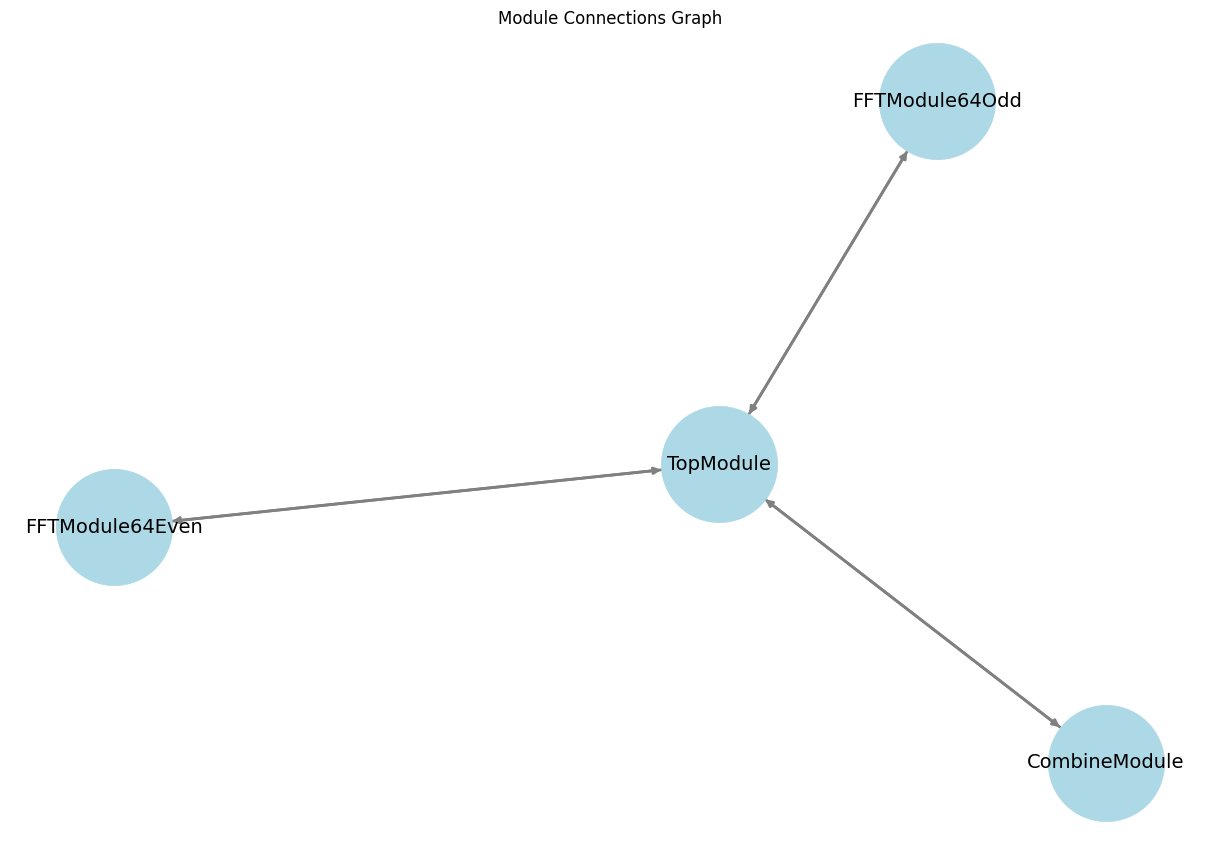

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

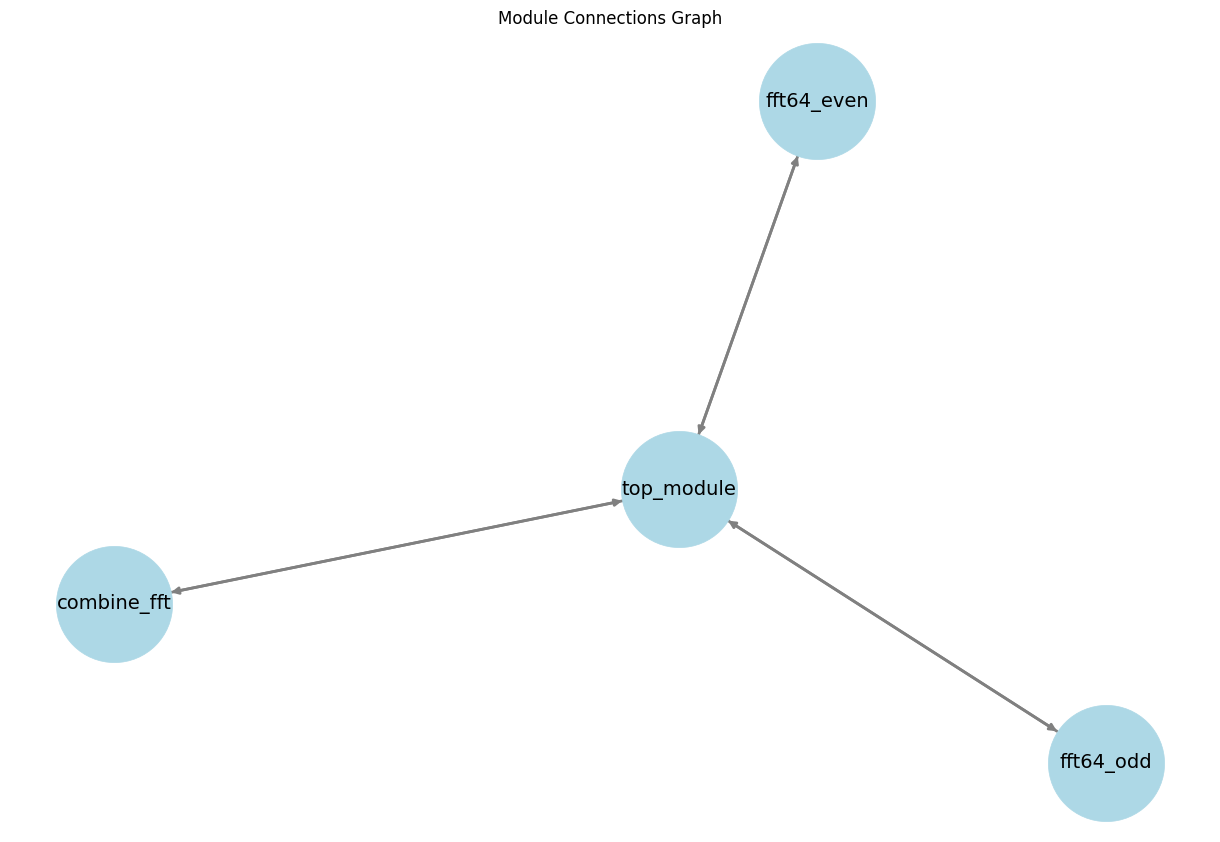

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design a 128-point FFT circuit using two pre-existing 64-point FFT modules.', 'Optimize the design for maximum performance, specifically focusing on speed.', 'Ensure the design is implemented in HLS C++ and is well-commented, particularly highlighting performance optimizations.']\n                    requirements:\n                    ['The circuit must accept an input array of 128 double precision fixed point real numbers.', 'Utilize the radix-2 DIT FFT algorithm to compute the 128-point FFT by leveraging two 64-point FFT modules.', 'Implement the design in HLS C++ with detailed comments explaining performance optimizations.', 'The design should efficiently handle the decomposition of the 128-point FFT into two 64-point FFTs, processing even-indexed and odd-i

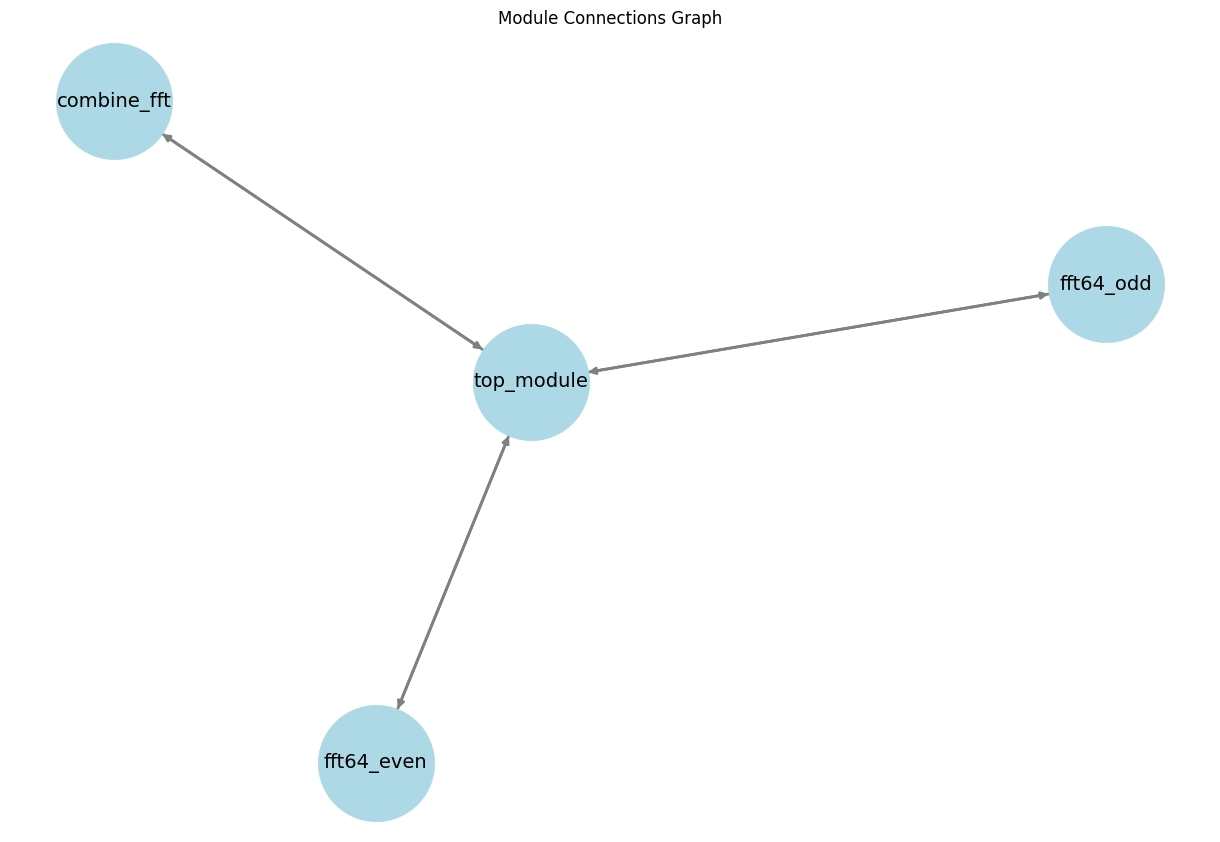

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

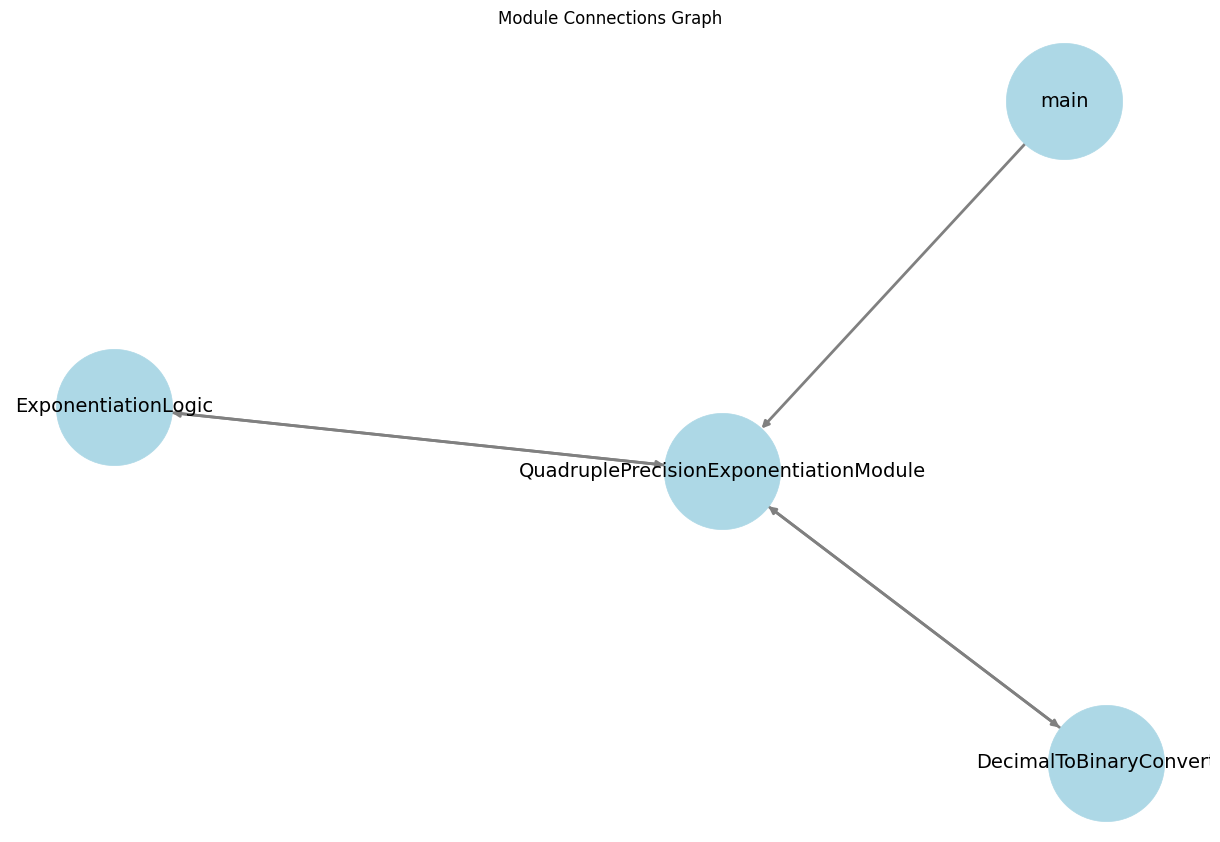

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

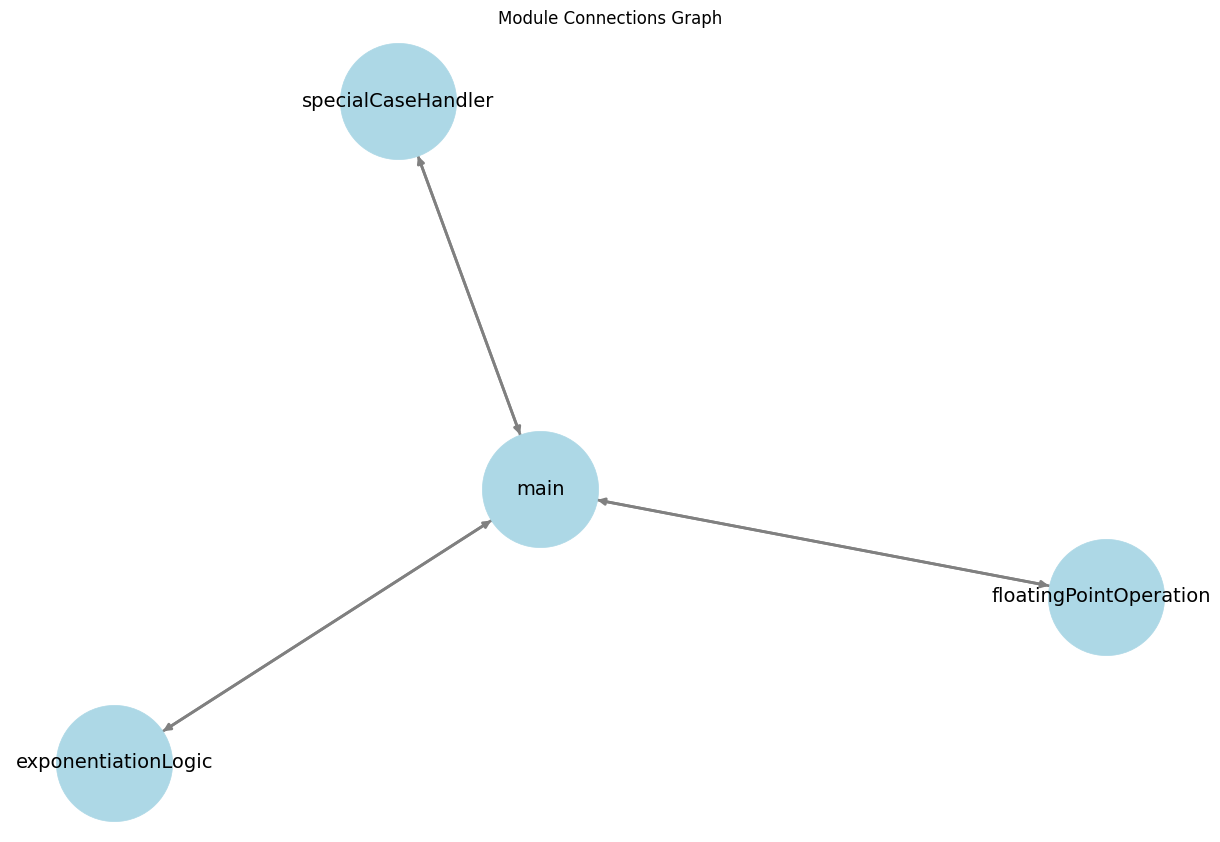

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

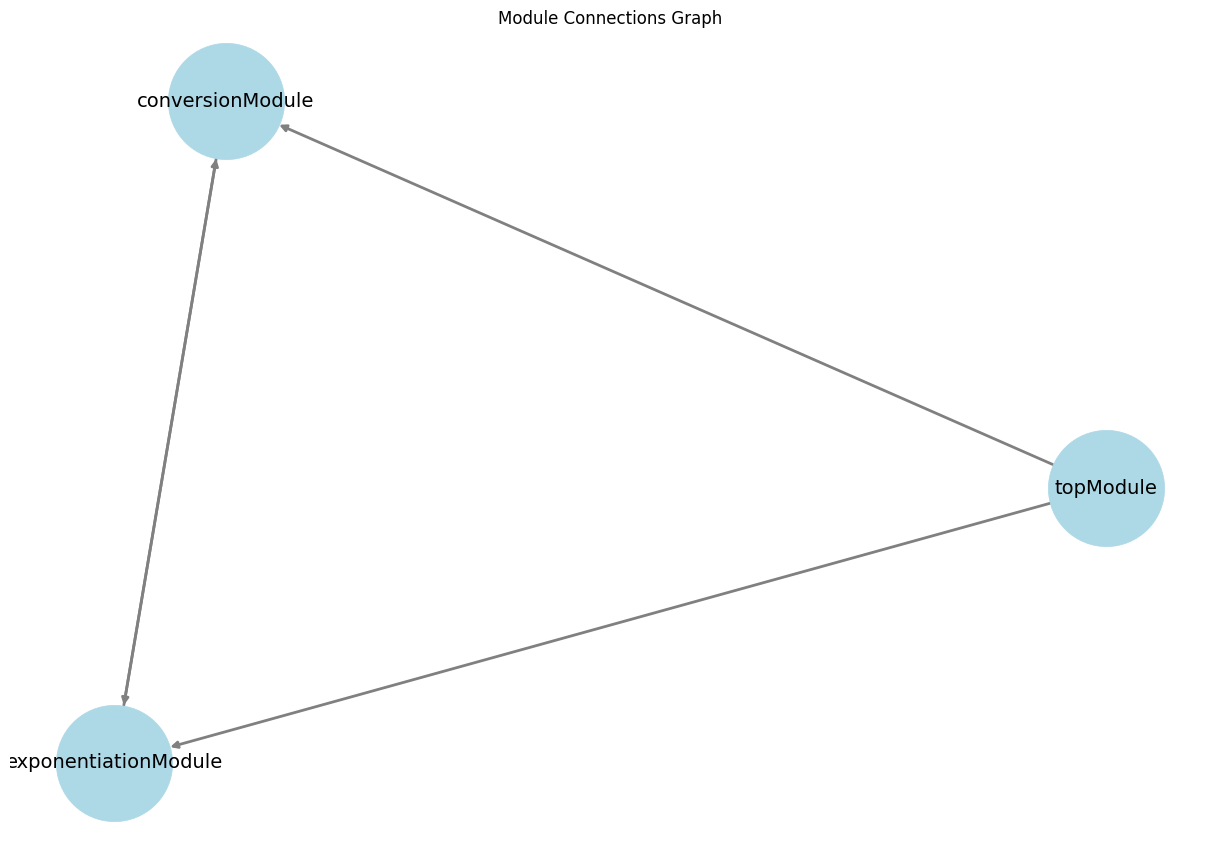

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

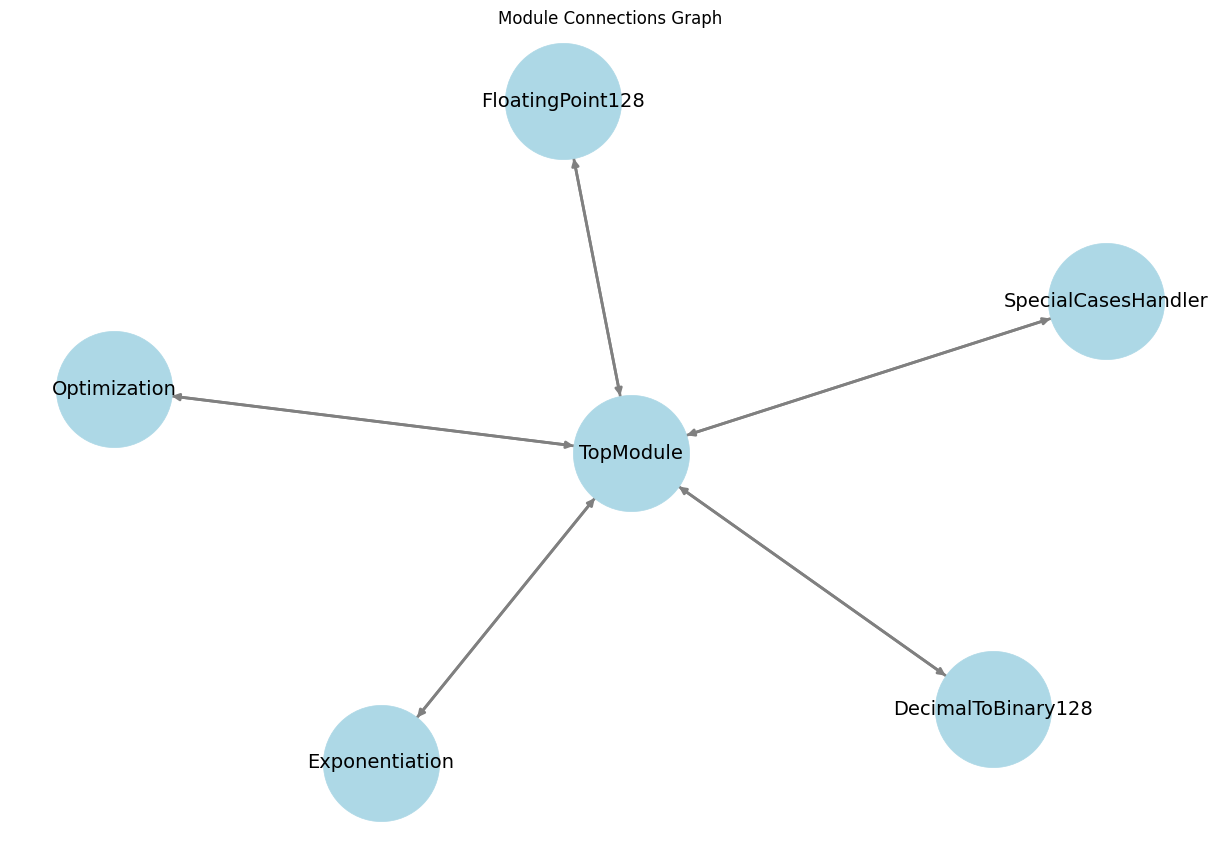

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

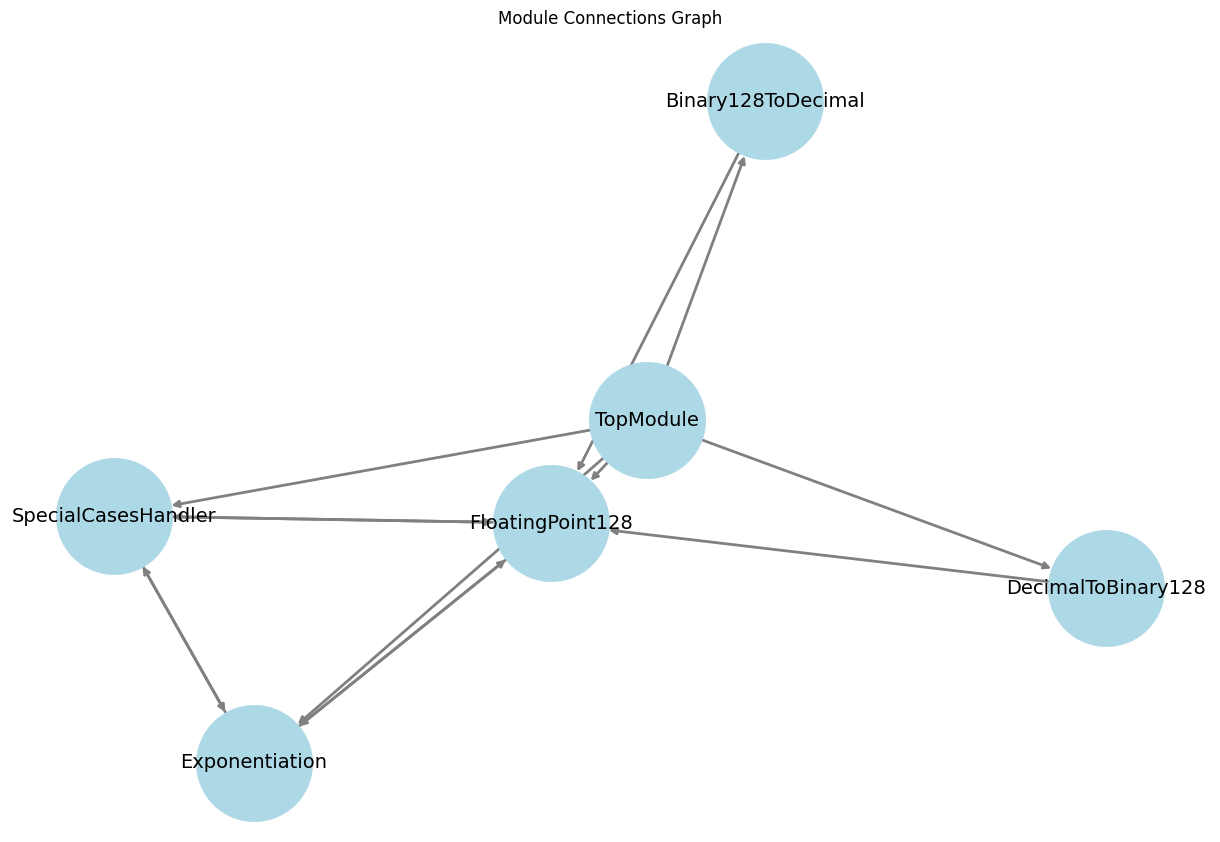

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

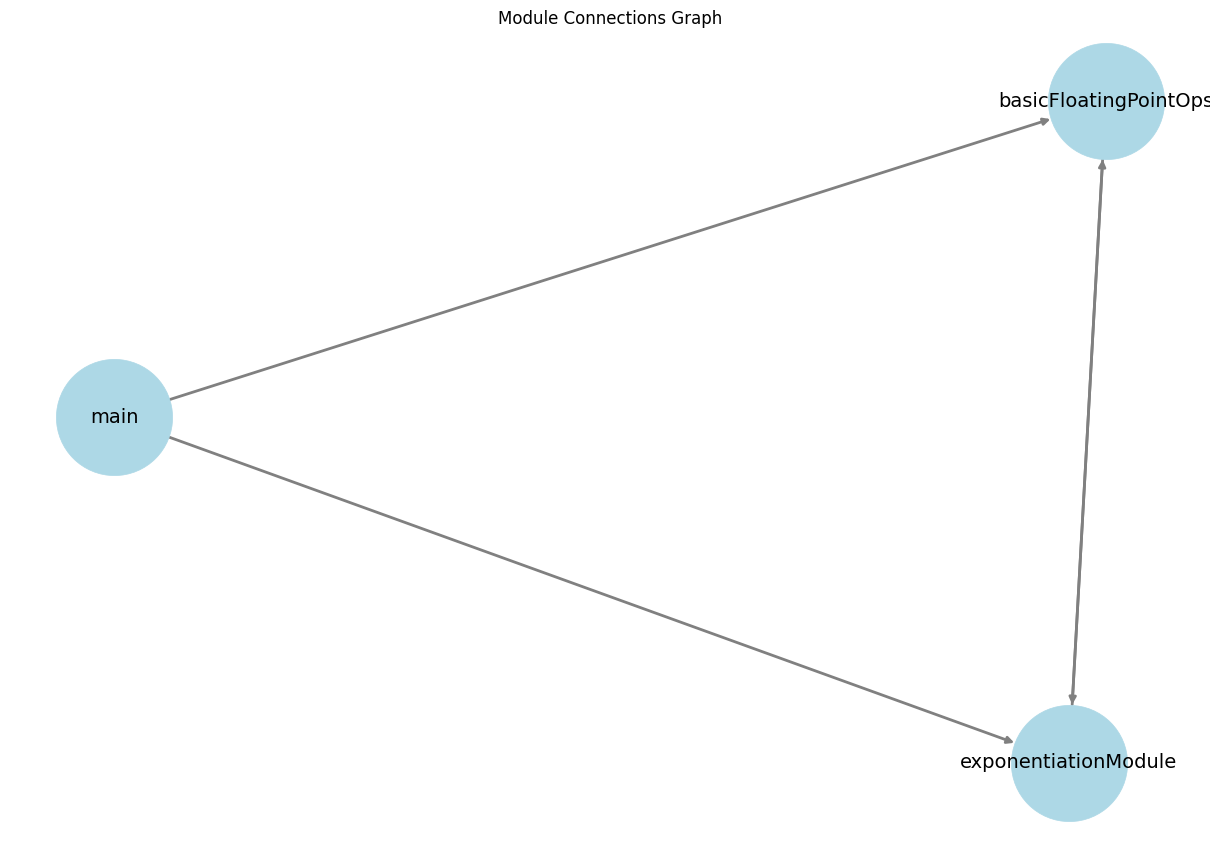

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

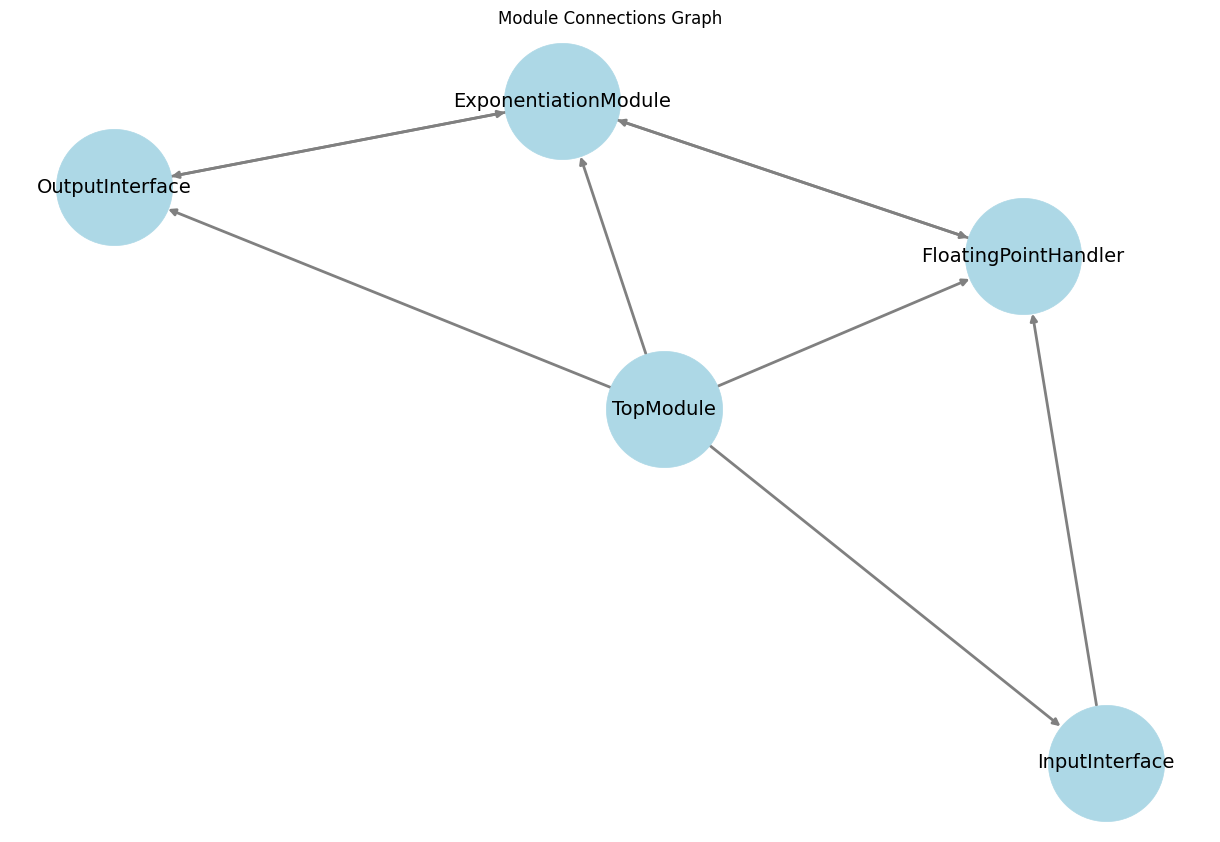

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point exponentiation module using a 128-bit floating point representation.', 'Ensure the module adheres to the IEEE 754-2008 binary128 standard for quadruple precision floating point numbers.', 'Optimize the module for accurate and reliable computation, minimizing overflow and round-off errors.']\n                    requirements:\n                    ['Implement a 128-bit floating point representation with 1 sign bit, 15 exponent bits, and 113 significand bits (112 explicitly stored, 1 implicit).', 'Follow the IEEE 754-2008 standard for binary128, including the encoding of the exponent using an offset binary representation with a bias of 16383.', 'Handle special cases in the floating point representation suc

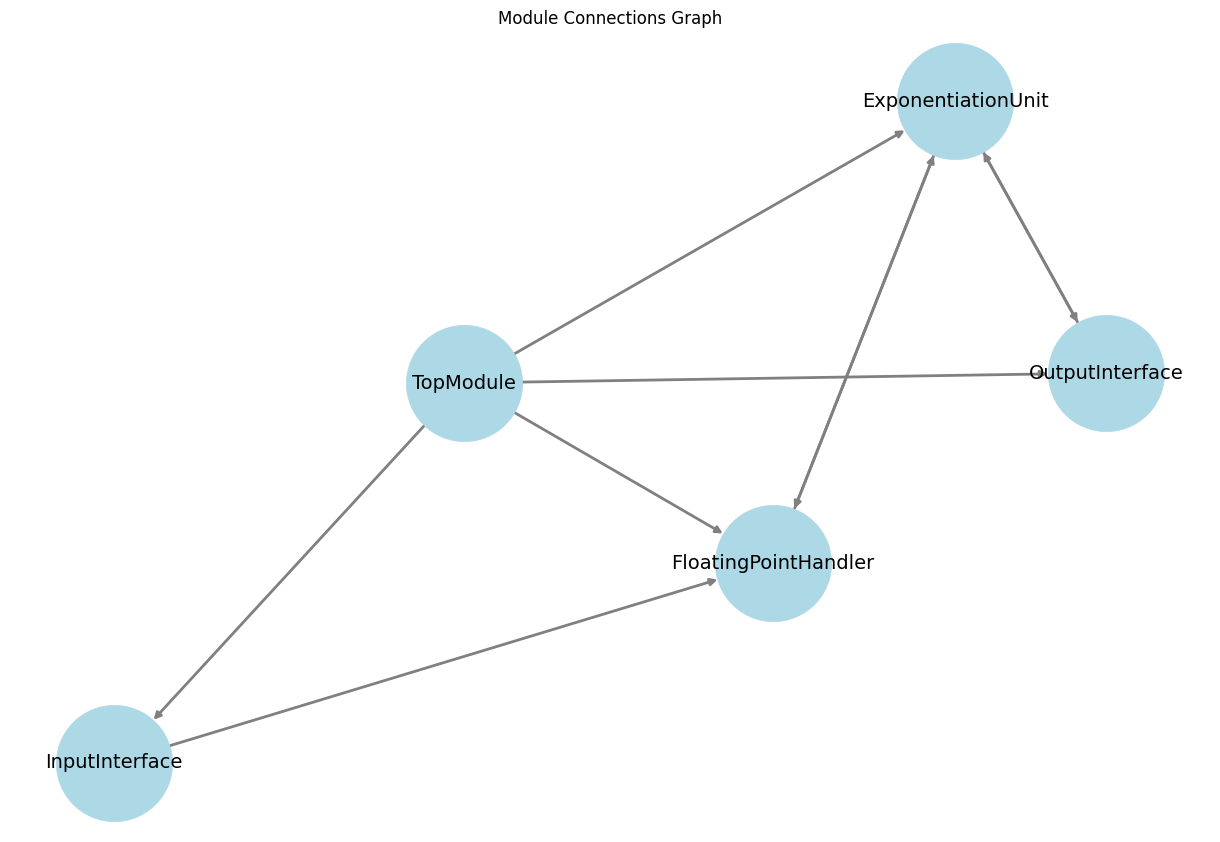

In [7]:
import importlib
from FPGA_AGI import tools
importlib.reload(tools)
from FPGA_AGI import parameters
importlib.reload(parameters)
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI import prompts
importlib.reload(prompts)
from FPGA_AGI import chains
importlib.reload(chains)
from langchain_core.prompts import HumanMessagePromptTemplate
from FPGA_AGI import agents
importlib.reload(agents)
from FPGA_AGI.agents import Engineer
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI.utils import plot_graph

llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-turbo', temperature=0)
gpt4 = ChatOpenAI(model='gpt-4', temperature=0)
gpt4o = ChatOpenAI(model='gpt-4o', temperature=0)

#review = None
for requirements, input_context, name in zip(
    [riscv_requirements, fft_requirements, float128_requirements],
    [rescv_concatenated_content, fft_concatenated_content, float128_concatenated_content],
    ['Risc-v', 'FFT', 'Float-128']):
    review = None
    for eval_mod in [bigllm, gpt4o]:
        for model in [llm, bigllm, gpt4o]:
            for i in range(2):
                sol_dir = f'{name}_{model.model_name}_evaluation_{eval_mod.model_name}_{i}'
                R = Engineer(model=model, evaluator_model=eval_mod, retriever=pdfsearch.as_retriever(search_kwargs={"k": 1}), solution_num=sol_dir)
                try:
                    if review:
                        R.lit_review_results = review
                    R.invoke(goals=requirements.goals, requirements=requirements.requirements, input_context= '')
                    with open(f"solution_{sol_dir}/goals_requirements.txt", "w") as file:
                        file.write("Goals: \n" + '\n'.join(requirements.goals) + "\nRequirements: \n" + '\n'.join(requirements.requirements))
                    plot_graph(R.hierarchical_solution_result, save_path=f"solution_{sol_dir}/graph.png")
                except:
                    pass
                review = R.lit_review_results